## Voice Activity Detection

Inspired by the course:  
Sequence Models by deeplearning.ai

<img src="images/time_freq.png" style="width:auto;height:500px;">

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

# Data synthesis: Creating a dataset 


## 1.1 - Listening to the data   


In [3]:
IPython.display.Audio("./audio_examples/music_00025.wav")

In [4]:
IPython.display.Audio("./audio_examples/dialog_00025.wav")

## 1.2 - From audio recordings to spectrograms

What really is an audio recording? A microphone records little variations in air pressure over time, and it is these little variations in air pressure that your ear also perceives as sound. You can think of an audio recording is a long list of numbers measuring the little air pressure changes detected by the microphone. We will use audio sampled at 44100 Hz (or 44100 Hertz). This means the microphone gives us 44100 numbers per second. Thus, a 10 second audio clip is represented by 441000 numbers (= $10 \times 44100$). 

It is quite difficult to figure out from this "raw" representation of audio whether someone is talking or not. In  order to help your sequence model more easily learn to detect voice activity, we will compute a *spectrogram* of the audio. The spectrogram tells us how much different frequencies are present in an audio clip at a moment in time. 


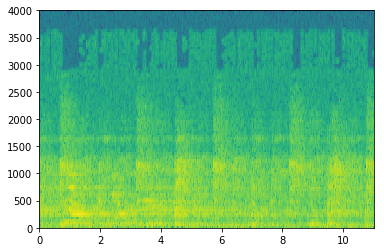

In [15]:
x = graph_spectrogram("./audio_examples/music_00025.wav")

/home/ai/anaconda3/envs/keras_tensorflow_gpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


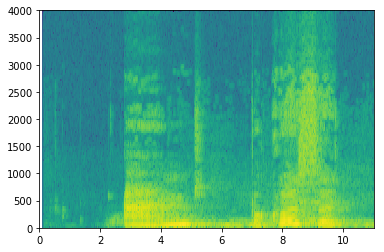

In [16]:
c_test = graph_spectrogram("./audio_examples/dialog_00025.wav")

The graph above represents how active each frequency is (y axis) over a number of time-steps (x axis). 

<img src="images/spectrogram.png" style="width:500px;height:200px;">
<center> **Figure 1**: Spectrogram of an audio recording, where the color shows the degree to which different frequencies are present (loud) in the audio at different points in time. Green squares means a certain frequency is more active or more present in the audio clip (louder); blue squares denote less active frequencies. </center>

The dimension of the output spectrogram depends upon the hyperparameters of the spectrogram software and the length of the input. In this notebook, we will be working with 2 second audio clips as the "standard length" for our training examples. The number of timesteps of the spectrogram will be 1101.


In [17]:
rate, data_conv = wavfile.read("audio_examples/music_00025.wav")
print("Time steps in audio recording before spectrogram", data_conv.shape)         # mono
# print("Time steps in audio recording before spectrogram", data_conv[:,0].shape)  # stereo
print("rate =", rate)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (88200,)
rate = 44100
Time steps in input after spectrogram (101, 1101)


Now, you can define:

In [5]:
Tx = 1101    # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [6]:
Ty = 1

## 1.3 - Generating a single training example

Because speech data is hard to acquire and label, we will synthesize the training data using the audio clips of musics, dialogs, and background noises. It is quite slow to record lots of 2 second audio clips with random dialogs in it. 

Because you had synthesized the dialog/no dialog over music and noise, we know exactly when in the 2sec clip a "dialog" occurs. This makes it easier to generate the labels $y^{\langle t \rangle}$. 

We will use the pydub package to manipulate audio. Pydub converts raw audio files into lists of Pydub data structures. Pydub uses 1ms as the discretization interval (1ms is 1 millisecond = 1/1000 seconds) which is why a 10sec clip is always represented using 10,000 steps. 

In [5]:
# Load audio segments using pydub 
dialogs, noises, musics = load_raw_audio()

print("music[0]: " + str(len(musics[0])))        # Should be 2000, since it is a 2 sec clip
print("dialogs[0]: " + str(len(dialogs[0])))     # Should be 2000, since it is a 2 sec clip
print("noises[0]: " + str(len(noises[0])))       # Should be 2000, since it is a 2 sec clip

print('music 10s audio count = ', len(musics))
print('dialogs audio count = ', len(dialogs))
print('noises 10s audio count = ', len(noises))

music[0]: 2000
dialogs[0]: 2000
noises[0]: 2000
music 10s audio count =  7957
dialogs audio count =  13228
noises 10s audio count =  994


---

In [6]:
def insert_audio_clip(background, audio_clip, previous_segments=None):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 2 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed; None 
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip.
    segment_time = (0, segment_ms-1)
    
    # Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [7]:
np.random.seed(1)
audio_clip, segment_time = insert_audio_clip(musics[0], dialogs[3])
#audio_clip, segment_time = insert_audio_clip(noises[1], dialogs[1])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (0, 1999)


In [8]:
def create_training_example(music, dialogs, noise, verbose=False):
    """
    Creates a training example with a given music, activates, and negatives.

    Arguments:
    music -- a 2 second music audio recording
    dialogs -- a list of audio segments of a conversation between two persons
    noise -- a 2 second noise audio recording

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """

    # Set the random seed
    #np.random.seed(18)

    # Make music quieter (random value up to 20 dB)
    dB_reduction = np.random.randint(0, 20)
    music = music - dB_reduction
    if verbose: print("music music -{0} dB".format(dB_reduction))

    # Initialize y (label vector) of zeros
    y = np.zeros((Ty))

    # Select 0 or 1 random "dialog" audio clips from the entire list of "dialogs" recordings
    number_of_dialogs = np.random.randint(0, 2)
    random_indices = np.random.randint(len(dialogs), size=number_of_dialogs)
    random_dialogs = [dialogs[i] for i in random_indices]

    # Loop over randomly selected "conversation" clips and insert in music
    for random_dialog in random_dialogs:
        # Make music quieter (random value up to 10 dB)
        dB_reduction = np.random.randint(0, 10)
        random_dialog = random_dialog - dB_reduction

        # Insert the audio clip on the music
        if verbose: print("dialog insertion... -{0} dB".format(dB_reduction))
        music, segment_time = insert_audio_clip(music, random_dialog)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = np.ones((Ty))
        if verbose: print("dialog inserted [{0}, {1}]".format(segment_start, segment_end))

    # insert the noise audio over music and optional dialog 
    music = music.overlay(noise, position=0)

    # Standardize the volume of the audio clip
    music = match_target_amplitude(music, -20.0)

    # Export new training example
    file_handle = music.export("train" + ".wav", format="wav")
    if verbose: print("File (train.wav) was saved in your directory.")

    # Get and plot spectrogram of the new recording (music with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")

    return x, y

music music -5 dB
dialog insertion... -8 dB
dialog inserted [0, 1999]
File (train.wav) was saved in your directory.


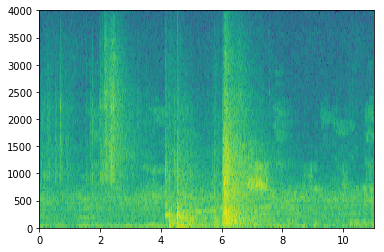

In [9]:
x, y = create_training_example(musics[1], dialogs, noises[1], verbose=True)

In [10]:
print('x.shape =', x.shape)
print('y.shape =', y.shape)

x.shape = (101, 1101)
y.shape = (1,)


In [11]:
print('x.transpose().shape =', x.transpose().shape)
print('y.transpose().shape =', y.transpose().shape)

x.transpose().shape = (1101, 101)
y.transpose().shape = (1,)


Now you can listen to the training example you created and compare it to the spectrogram generated above.

In [12]:
IPython.display.Audio("train.wav")

In [13]:
y

array([1.])

## 1.4 - Full training set


In [14]:
def create_dev_dataset(Tx, Ty, n_freq, musics, dialogs, noises, max_samples=1500):
    print('number of music samples =', len(musics))
    n_x = min(len(musics)-1, max_samples)
    print('number of training samples =', n_x)

    X = np.zeros((n_x, Tx, n_freq))
    Y = np.zeros((n_x, Ty))

    noise_index = 0
    for i in range(n_x):
        if i % 100 == 0:
            print('sample {0}/{1}'.format(i, n_x))

        x, y = create_training_example(musics[i], dialogs, noises[noise_index], verbose=False)

        X[i] = x.transpose()
        Y[i] = y.transpose()

        noise_index = noise_index + 1 if noise_index < len(noises)-1 else 0

    return X, Y

number of music samples = 7957
number of training samples = 5000
sample 0/5000
sample 100/5000
sample 200/5000
sample 300/5000
sample 400/5000
sample 500/5000
sample 600/5000
sample 700/5000
sample 800/5000
sample 900/5000
sample 1000/5000
sample 1100/5000
sample 1200/5000
sample 1300/5000
sample 1400/5000
sample 1500/5000
sample 1600/5000
sample 1700/5000
sample 1800/5000
sample 1900/5000
sample 2000/5000
sample 2100/5000
sample 2200/5000
sample 2300/5000
sample 2400/5000
sample 2500/5000
sample 2600/5000
sample 2700/5000
sample 2800/5000
sample 2900/5000
sample 3000/5000
sample 3100/5000
sample 3200/5000
sample 3300/5000
sample 3400/5000
sample 3500/5000
sample 3600/5000
sample 3700/5000
sample 3800/5000
sample 3900/5000
sample 4000/5000
sample 4100/5000
sample 4200/5000
sample 4300/5000
sample 4400/5000
sample 4500/5000
sample 4600/5000
sample 4700/5000
sample 4800/5000
sample 4900/5000


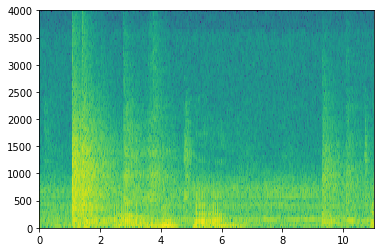

In [15]:
# create dataset
X, Y = create_dev_dataset(Tx, Ty, n_freq, musics, dialogs, noises, max_samples=5000)
np.save('../data/dev_set_to_one_5000_x.npy', X)
np.save('../data/dev_set_to_one_5000_y.npy', Y)  

# load previously saved dev dataset
#X = np.load('../data/dev_set_to_one_5000_x.npy')
#Y = np.load('../data/dev_set_to_one_5000_y.npy')

In [16]:
X.shape

(5000, 1101, 101)

In [17]:
print(Y.shape)
print('Y[2] =', Y[2])

(5000, 1)
Y[2] = [0.]


## 1.5 - Test set


In [18]:
def create_test_dataset(Tx, Ty, n_freq):
    with_dialog_files = glob.glob('../data/test_set_wav/test_with_dialog_*')
    without_dialog_files = glob.glob('../data/test_set_wav/test_without_dialog_*')

    n_x = len(with_dialog_files) + len(without_dialog_files)

    X_test = np.zeros((n_x, Tx, n_freq))
    #Y_test = np.zeros((n_x, Ty, 1))
    Y_test = np.zeros((n_x, Ty))

    print('number of test samples = {} ({} with and {} without dialogs)'.format(n_x, len(with_dialog_files), len(without_dialog_files)))

    sample_index = 0
    for i, audio_file in enumerate(with_dialog_files):
        print('   with dialog sample {} - {}/{}: {}'.format(sample_index, i, len(with_dialog_files), audio_file))

        x = graph_spectrogram(audio_file)

        X_test[sample_index] = x.transpose()
        Y_test[sample_index] = np.ones((Ty, 1))
        sample_index += 1

    for i, audio_file in enumerate(without_dialog_files):
        print('without dialog sample {} - {}/{}: {}'.format(sample_index, i, len(without_dialog_files), audio_file))

        x = graph_spectrogram(audio_file)

        X_test[sample_index] = x.transpose()
        Y_test[sample_index] = np.zeros((Ty, 1))
        sample_index += 1

    return X_test, Y_test

number of test samples = 181 (90 with and 91 without dialogs)
   with dialog sample 0 - 0/90: ../data/test_set_wav/test_with_dialog_00186.wav
   with dialog sample 1 - 1/90: ../data/test_set_wav/test_with_dialog_00142.wav
   with dialog sample 2 - 2/90: ../data/test_set_wav/test_with_dialog_00156.wav
   with dialog sample 3 - 3/90: ../data/test_set_wav/test_with_dialog_00129.wav
   with dialog sample 4 - 4/90: ../data/test_set_wav/test_with_dialog_00147.wav
   with dialog sample 5 - 5/90: ../data/test_set_wav/test_with_dialog_00137.wav
   with dialog sample 6 - 6/90: ../data/test_set_wav/test_with_dialog_00153.wav
   with dialog sample 7 - 7/90: ../data/test_set_wav/test_with_dialog_00143.wav
   with dialog sample 8 - 8/90: ../data/test_set_wav/test_with_dialog_00155.wav
   with dialog sample 9 - 9/90: ../data/test_set_wav/test_with_dialog_00168.wav
   with dialog sample 10 - 10/90: ../data/test_set_wav/test_with_dialog_00141.wav
   with dialog sample 11 - 11/90: ../data/test_set_wav/t

/home/ai/anaconda3/envs/keras_tensorflow_gpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


   with dialog sample 70 - 70/90: ../data/test_set_wav/test_with_dialog_00139.wav
   with dialog sample 71 - 71/90: ../data/test_set_wav/test_with_dialog_00151.wav
   with dialog sample 72 - 72/90: ../data/test_set_wav/test_with_dialog_00146.wav
   with dialog sample 73 - 73/90: ../data/test_set_wav/test_with_dialog_00164.wav
   with dialog sample 74 - 74/90: ../data/test_set_wav/test_with_dialog_00105.wav
   with dialog sample 75 - 75/90: ../data/test_set_wav/test_with_dialog_00167.wav
   with dialog sample 76 - 76/90: ../data/test_set_wav/test_with_dialog_00177.wav
   with dialog sample 77 - 77/90: ../data/test_set_wav/test_with_dialog_00111.wav
   with dialog sample 78 - 78/90: ../data/test_set_wav/test_with_dialog_00104.wav
   with dialog sample 79 - 79/90: ../data/test_set_wav/test_with_dialog_00161.wav
   with dialog sample 80 - 80/90: ../data/test_set_wav/test_with_dialog_00158.wav
   with dialog sample 81 - 81/90: ../data/test_set_wav/test_with_dialog_00175.wav
   with dialog s

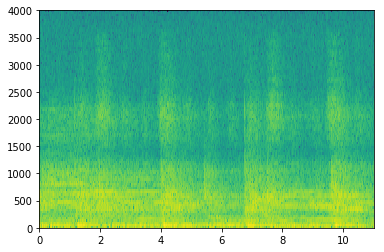

In [19]:
# create test set
X_test, Y_test = create_test_dataset(Tx, Ty, n_freq)
# np.save('../data/test_set_x.npy', X_test)
# np.save('../data/test_set_y.npy', Y_test)

# load previously saved test dataset
#X_test = np.load('../data/test_set_x.npy')
#Y_test = np.load('../data/test_set_y.npy')

---

# 2 - Model


The model will use 1-D convolutional layers, LSTM layers, and dense layers.

In [8]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

## 2.1 - Build the model

Here is the architecture.

One key step of this model is the 1D convolutional step (near the bottom of Figure 3). It inputs the 1101 step spectrogram, and outputs a 272 step output, which is then further processed by multiple a dense layer to get the final $T_y = 1$ step output. This layer plays a role similar to a 2D convolutions, of extracting low-level features and then possibly generating an output of a smaller dimension. 

Computationally, the 1-D conv layer also helps speed up the model because now the LSTM  has to process only 272 timesteps rather than 5511 timesteps. The two GRU layers read the sequence of inputs from left to right, then ultimately uses a dense+sigmoid layer to make a prediction for $y^{\langle t \rangle}$. Because $y$ is binary valued (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1, corresponding to the user talking.


In [9]:
def model_lstm_bi_many_to_one(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # CONV layer
    X = Conv1D(196, 15, strides=4)(X_input)  # CONV1D
    X = BatchNormalization()(X)              # Batch normalization
    X = Activation('relu')(X)                # ReLu activation
    X = Dropout(0.1)(X)                      # dropout (use 0.8)

    # First LSTM Layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)  # LSTM (use 128 units and return the sequences)
    X = Dropout(0.1)(X)                      # dropout (use 0.8)
    X = BatchNormalization()(X)              # Batch normalization
    
    # Second LSTM Layer
    X = Bidirectional(LSTM(128))(X)          # LSTM (use 128 units)
    X = Dropout(0.1)(X)                      # dropout (use 0.8)
    X = BatchNormalization()(X)              # Batch normalization
    X = Dropout(0.1)(X)                      # dropout (use 0.8)

    # dense layer
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = BatchNormalization()(X)

    # 1 unit dense layer
    X = Dense(1, activation = "sigmoid")(X)  # one unit dense (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [10]:
model = model_lstm_bi_many_to_one(input_shape = (Tx, n_freq))

# Save the model architecture
with open('../models/lstm_bi_many_to_one_model_architecture.json', 'w') as f:
    f.write(model.to_json())

Let's print the model summary to keep track of the shapes.

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1101, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 196)          297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 272, 196)          784       
_________________________________________________________________
activation_1 (Activation)    (None, 272, 196)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 272, 196)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 272, 256)          332800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 272, 256)          0         
__________

The output of the network is of shape (None, 1) while the input is (None, 1101, 101). The Conv1D has reduced the number of steps from 1101 at spectrogram to 272. 

## 2.2 - Fit the model

In [79]:
opt = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

---

In [80]:
model.fit(X, Y, batch_size = 200, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 8s - loss: 1.3907 - acc: 0.4867     
Epoch 2/10
1500/1500 [==============================] - 7s - loss: 1.3529 - acc: 0.4833     
Epoch 3/10
1500/1500 [==============================] - 7s - loss: 1.3426 - acc: 0.4960     
Epoch 4/10
1500/1500 [==============================] - 7s - loss: 1.3236 - acc: 0.4873     
Epoch 5/10
1500/1500 [==============================] - 7s - loss: 1.3048 - acc: 0.4913     
Epoch 6/10
1500/1500 [==============================] - 7s - loss: 1.2854 - acc: 0.4913     
Epoch 7/10
1500/1500 [==============================] - 7s - loss: 1.3402 - acc: 0.4853     
Epoch 8/10
1500/1500 [==============================] - 7s - loss: 1.2657 - acc: 0.4967     
Epoch 9/10
1500/1500 [==============================] - 7s - loss: 1.3546 - acc: 0.4880     
Epoch 10/10
1500/1500 [==============================] - 7s - loss: 1.2967 - acc: 0.4827     


In [39]:
model.save_weights("../models/lstm_bi__many_to_one_23_11_2018_weights_1.h5")

---

## 2.3 - Test the model


In [12]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('../models/lstm_bi_many_to_one_model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

model.load_weights('../models/lstm_bi__many_to_one_23_11_2018_weights_1.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1101, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 196)          297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 272, 196)          784       
_________________________________________________________________
activation_1 (Activation)    (None, 272, 196)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 272, 196)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 272, 256)          332800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 272, 256)          0         
__________

In [41]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [42]:
loss, acc = model.evaluate(X_test, Y_test)
print("Test set accuracy = ", acc)

181/181 [==============================] - 1s     
Test set accuracy =  0.8138202814107441


---

# 3 - Making Predictions


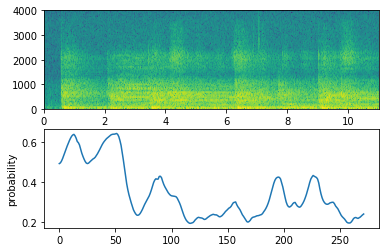

In [45]:
filename = '../data/test_set/test_with_dialog_00105.wav'
rate, data = get_wav_info(filename)

plt.subplot(2, 1, 1)  # spectrogram on top

x = graph_spectrogram(wav_file=None, rate=rate, data=data)

# the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
x = x.swapaxes(0,1)
x = np.expand_dims(x, axis=0)

predictions = model.predict(x)

plt.subplot(2, 1, 2)  # probability plot at the bottom
plt.plot(predictions[0,:,0])
plt.ylabel('probability')
plt.show()

---

# 4 - Try it LIVE!


In [67]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

In [66]:
import pyaudio
import wave

def start_live_recording(record_time = 10, output_filename = 'live_output.wav'):
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = record_time
    WAVE_OUTPUT_FILENAME = output_filename

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording")

    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

---

In [68]:
live_output_filename = 'live_output.wav'

start_live_recording(record_time = 10, output_filename = live_output_filename)
preprocess_audio(live_output_filename)

OSError: [Errno -9996] Invalid input device (no default output device)

In [ ]:
IPython.display.Audio(live_output_filename) # listen to the audio you uploaded 